In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ensembles import GradientBoostingMSE, RandomForestMSE, rmse

## Предобработка данных

In [2]:
def date_to_ymd(line):
    y, m, d = line['date'].split('-')
    line['year'] = int(y)
    line['month'] = int(m)
    line['day'] = int(d)
    
    return line

In [3]:
x = pd.read_csv('./data/train_data.csv').apply(date_to_ymd, axis=1).drop(['id', 'index', 'date'], axis=1).values[:, 1:]
y = pd.read_csv('./data/train_target.csv').values[:,1]

In [4]:
train_size = int(x.shape[0] * 0.66)
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

## Случайный лес

In [5]:
n_estimators_max_value = 100
subsample_values = np.linspace(0.1, 1., 15)
max_depth_values = [1, 3, 5, 7, 10, 20, None]

### Зависимость качества от числа моделей в ансамбле

In [6]:
rmse_train, rmse_test = [], []
times = []

model = RandomForestMSE(n_estimators=n_estimators_max_value, feature_subsample_size=int(0.5 * x_train.shape[1]))
rmse_train, rmse_test, times = model.fit(x_train, y_train, x_test, y_test)

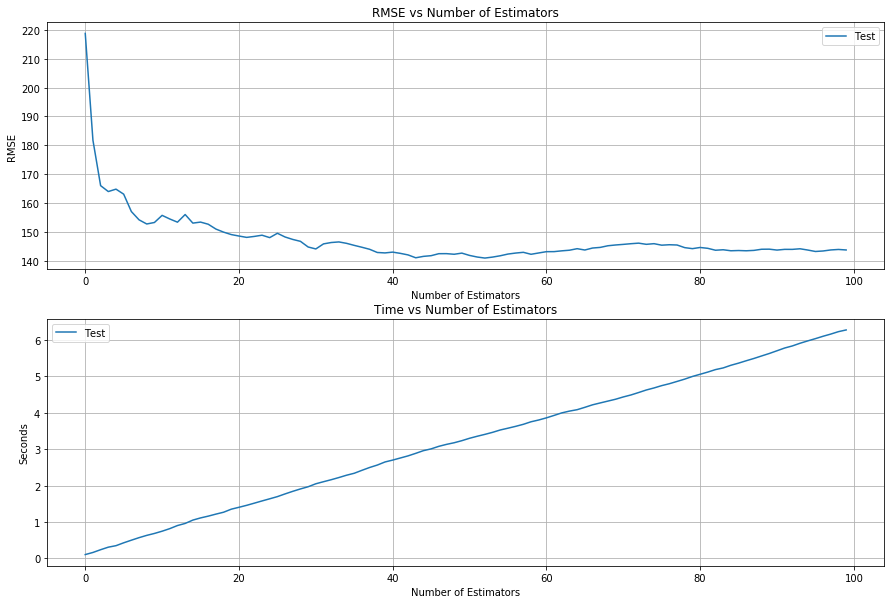

In [7]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(rmse_test, label='Test')
ax_1.set_xlabel('Number of Estimators')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Number of Estimators')
ax_1.grid()
ax_1.legend()

ax_2.plot(times, label='Test')
ax_2.set_xlabel('Number of Estimators')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Number of Estimators')
ax_2.grid()
ax_2.legend()

1. Ожидаемо, что при увеличении числа эстиматоров качество сначала резко падает, а затем выходит на плато. 
2. Так как все базовые модели в ансамбле одинаковые, то и время обучения линейно зависит от числа этих моделей. 

### Зависимость качества от доли признаков, используемых для обучения очередного алгоритма

In [8]:
rmse_train, rmse_test = [], []
times = []

for subsample in subsample_values:
    st = time.time()
    
    model = RandomForestMSE(n_estimators=50, feature_subsample_size=int(x_train.shape[1] * subsample))
    _, __, ___ = model.fit(x_train, y_train, x_test, y_test)
    rmse_train.append(_[-1])
    rmse_test.append(__[-1])

    times.append(time.time() - st)

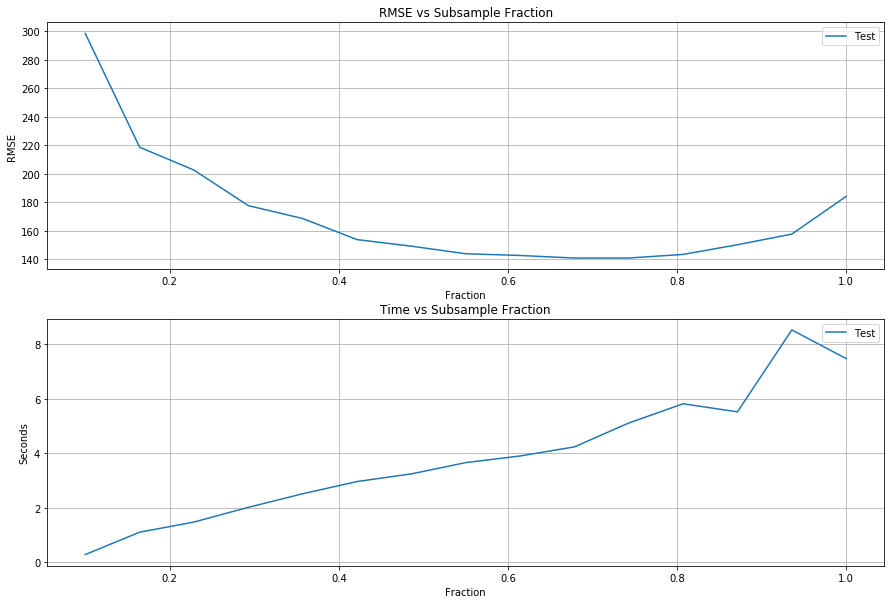

In [9]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(subsample_values, rmse_test, label='Test')
ax_1.set_xlabel('Fraction')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Subsample Fraction')
ax_1.grid()
ax_1.legend()

ax_2.plot(subsample_values, times, label='Test')
ax_2.set_xlabel('Fraction')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Subsample Fraction')
ax_2.grid()
ax_2.legend()

1. Можно видеть, что качество достигает своего максимума при промежуточном (между 0. и 1.) значении. Это связано с тем, что при малых долях признаков, модель суммарно использовала меньшее число данных для обучения, и, как следствие, недообучается. При больших значениях параметра, модель начинает страдать от недостатка разнообразия между разными эстиматорами в ансамбле, что приводит к низкой генерализации и худшему качеству на отложенной выборке.
2. Так как время построения одного дерева линейно зависит от размера признакого пространства, то и построение всего случайного леса имеет прямую пропорциональность в зависимости от времени, что и можно видеть на графике.

### Зависимость качества от максимальной глубины дерева в ансамбле

In [10]:
rmse_train, rmse_test = [], []
times = []

for max_depth in max_depth_values:
    st = time.time()
    
    model = RandomForestMSE(n_estimators=500, max_depth=max_depth)
    _, __, ___ = model.fit(x_train, y_train, x_test, y_test)
    rmse_train.append(_[-1])
    rmse_test.append(__[-1])

    times.append(time.time() - st)

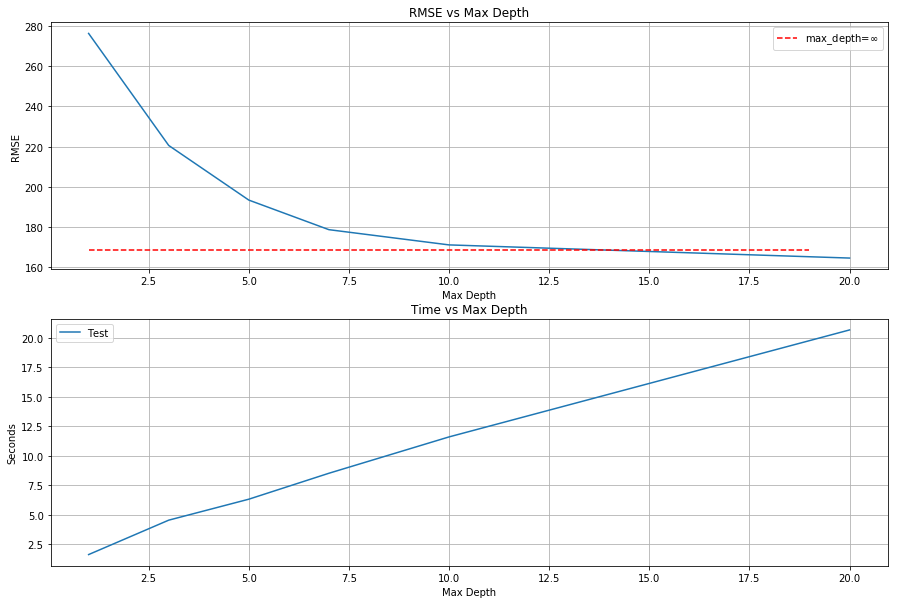

In [11]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(max_depth_values, rmse_test)
ax_1.plot(list(range(max_depth_values[0], max_depth_values[-2])), [rmse_test[-1] for _ in range(max_depth_values[0], max_depth_values[-2])], 'r--', label='max_depth=$\infty$') 
ax_1.set_xlabel('Max Depth')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Max Depth')
ax_1.grid()
ax_1.legend()

ax_2.plot(max_depth_values, times, label='Test')
ax_2.set_xlabel('Max Depth')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Max Depth')
ax_2.grid()
ax_2.legend()

1. Как можно видеть из графика выше, случайный лес имеет тенденцию к увеличению качества с ростом максимальной глубины базовых деревьев. Однако, при неограниченной глубине деревьев, алгоритм начинает переобучаться, что приводит к снижению качества.
2. Логично, что с увеличением глубины деревьев, время их построения увеличивается. Действительно, данную зависимость можно наблюдать на втором графике.

## Градиентный бустинг

In [12]:
n_estimators_max_value = 100
subsample_values = np.linspace(0.1, 1., 15)
max_depth_values = [1, 3, 5, 7, 10, 20, None]
learning_rate_values = np.logspace(-2.5, 0, 15)

### Зависимость качества от числа моделей в ансамбле

In [13]:
rmse_train, rmse_test = [], []
times = []

model = GradientBoostingMSE(n_estimators=n_estimators_max_value, min_samples_leaf=15)
rmse_train, rmse_test, times = model.fit(x_train, y_train, x_test, y_test)

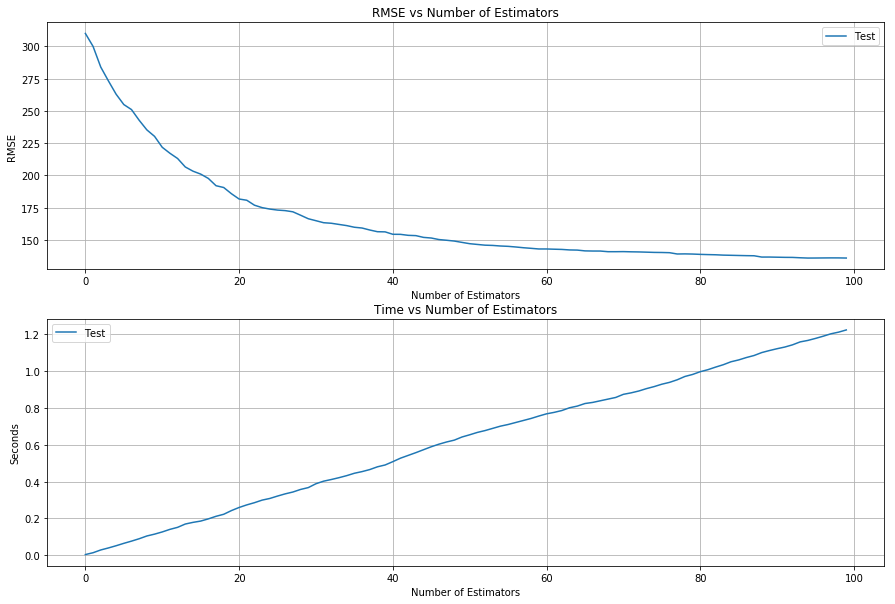

In [14]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(rmse_test, label='Test')
ax_1.set_xlabel('Number of Estimators')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Number of Estimators')
ax_1.grid()
ax_1.legend()

ax_2.plot(times, label='Test')
ax_2.set_xlabel('Number of Estimators')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Number of Estimators')
ax_2.grid()
ax_2.legend()

Аналогично случайному лесу в градиентном бустинге прослеживаются две тенденции:
1. При увеличении числа эстиматоров качество убывает, выходя на плато при большом числе базовых моделей. 
2. Время обучения линейно зависит от числа эстиматоров. 

### Зависимость качества от доли признакого пространства, используемой для обучения очередного алгоритма

In [15]:
rmse_train, rmse_test = [], []
times = []

for subsample in subsample_values:
    st = time.time()
    
    model = GradientBoostingMSE(n_estimators=100, feature_subsample_size=int(x_train.shape[1] * subsample), min_samples_leaf=15)
    _, __, ___ = model.fit(x_train, y_train, x_test, y_test)
    rmse_train.append(_[-1])
    rmse_test.append(__[-1])

    times.append(time.time() - st)

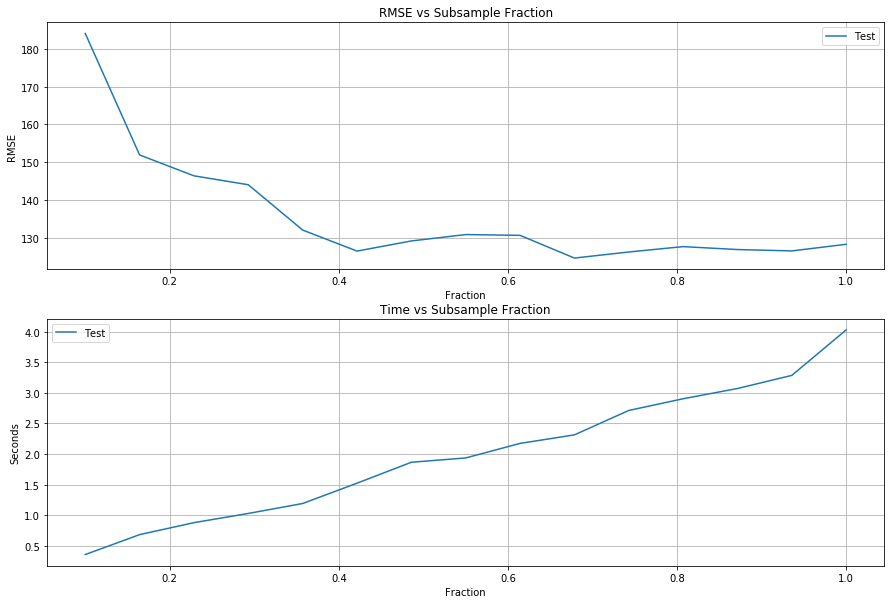

In [16]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(subsample_values, rmse_test, label='Test')
ax_1.set_xlabel('Fraction')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Subsample Fraction')
ax_1.grid()
ax_1.legend()

ax_2.plot(subsample_values, times, label='Test')
ax_2.set_xlabel('Fraction')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Subsample Fraction')
ax_2.grid()
ax_2.legend()

Как можно видеть, с увеличением доли признакого пространства, используемого для обучения, качество модели увеличивается. При этом, начиная с некоторого момента, увеличение этой доли не вносит значительного улучшения результата на отложенной выборке. Как следствие, возможно использовать меньшие значения параметра, достигая того же результата, что и при использовании всей выборки, но при этом тратя на работу алгоритма значительно меньше времени.

### Зависимость качества от максимальной глубины дерева в ансамбле

In [17]:
rmse_train, rmse_test = [], []
times = []

for max_depth in max_depth_values:
    st = time.time()
    
    model = GradientBoostingMSE(n_estimators=1000, learning_rate=0.01, max_depth=max_depth, min_samples_leaf=15)
    _, __, ___ = model.fit(x_train, y_train, x_test, y_test)
    rmse_train.append(_[-1])
    rmse_test.append(__[-1])

    times.append(time.time() - st)

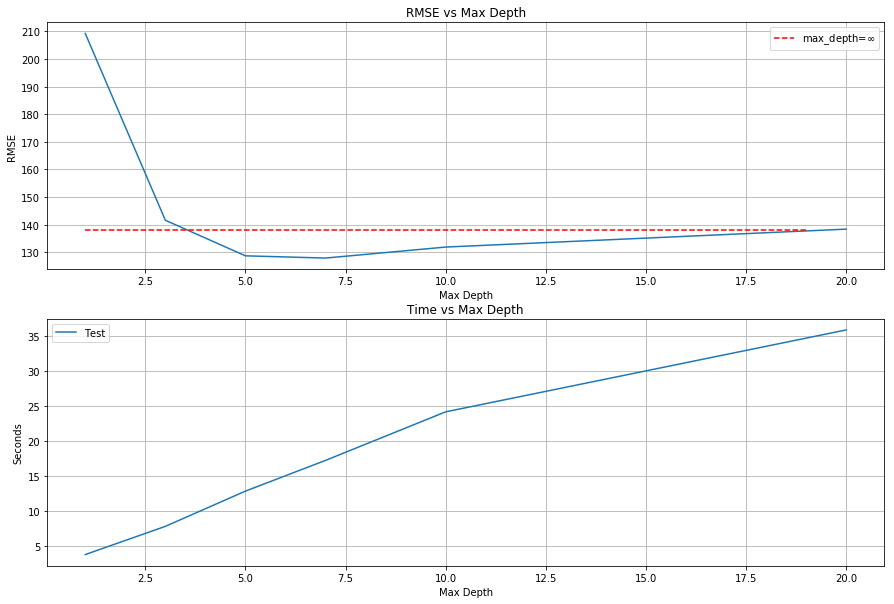

In [18]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(max_depth_values, rmse_test)
ax_1.plot(list(range(max_depth_values[0], max_depth_values[-2])), [rmse_test[-1] for _ in range(max_depth_values[0], max_depth_values[-2])], 'r--', label='max_depth=$\infty$') 
ax_1.set_xlabel('Max Depth')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Max Depth')
ax_1.grid()
ax_1.legend()

ax_2.plot(max_depth_values, times, label='Test')
ax_2.set_xlabel('Max Depth')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Max Depth')
ax_2.grid()
ax_2.legend()

Так как в алгоритме градиентного бустинга добавление переобученных моделей на первых итерациях ведёт к снижению обобщающей способности, то использование глубоких деревьев вызывает именно этот эффект. Как следствие, оптимальное знчение глубины деревьев --- промежуточное между очень глубокими и неглубокими деревьями.

### Зависимость качества от learning rate

In [19]:
rmse_train, rmse_test = [], []
times = []

for learning_rate in learning_rate_values:
    st = time.time()
    
    model = GradientBoostingMSE(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=15)
    _, __, ___ = model.fit(x_train, y_train, x_test, y_test)
    rmse_train.append(_[-1])
    rmse_test.append(__[-1])

    times.append(time.time() - st)

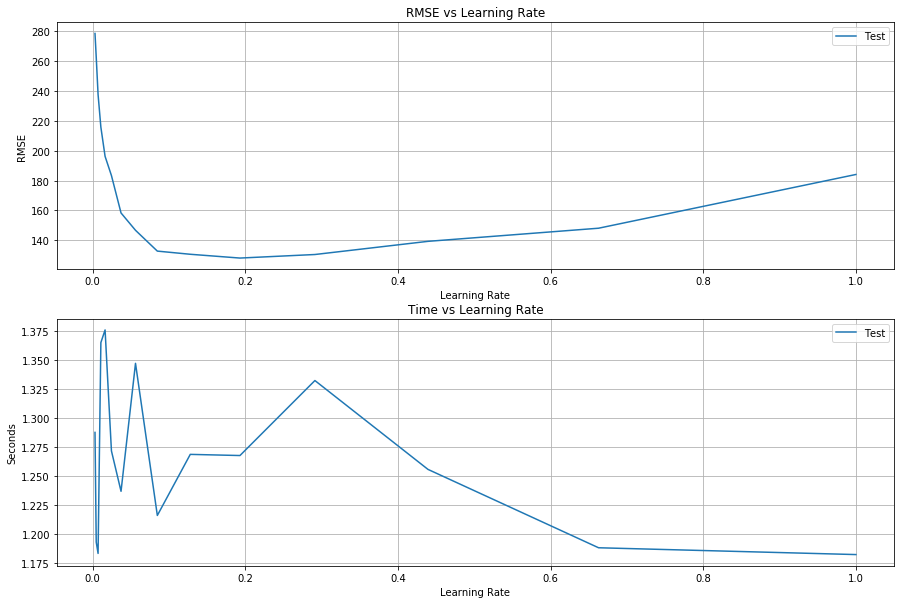

In [20]:
fig, (ax_1, ax_2) = plt.subplots(2, 1, figsize=(15, 10))

ax_1.plot(learning_rate_values, rmse_test, label='Test')
ax_1.set_xlabel('Learning Rate')
ax_1.set_ylabel('RMSE')
ax_1.set_title('RMSE vs Learning Rate')
ax_1.grid()
ax_1.legend()

ax_2.plot(learning_rate_values, times, label='Test')
ax_2.set_xlabel('Learning Rate')
ax_2.set_ylabel('Seconds')
ax_2.set_title('Time vs Learning Rate')
ax_2.grid()
ax_2.legend()

Из первого графика можно видеть, что оптимальное значение learning rate достигается между 0. и 1. В качестве объяснения можно предположить, что при слишком малениких значениях, модель не успевает сходится к тому же результату, что и модель с оптимальным значением параметра. При этом большие значения learning rate, напросив, приводят к быстой сходимости в локальный оптимум на обучающей выборке и, как следствие, к худшей обобщающей способности. То есть модель, обучив на первых итерациях "хорошие" базовые модели, лишает возможности последующим деревьям эффективно исправить ошибки первых моделей и повысить генерализацию.  